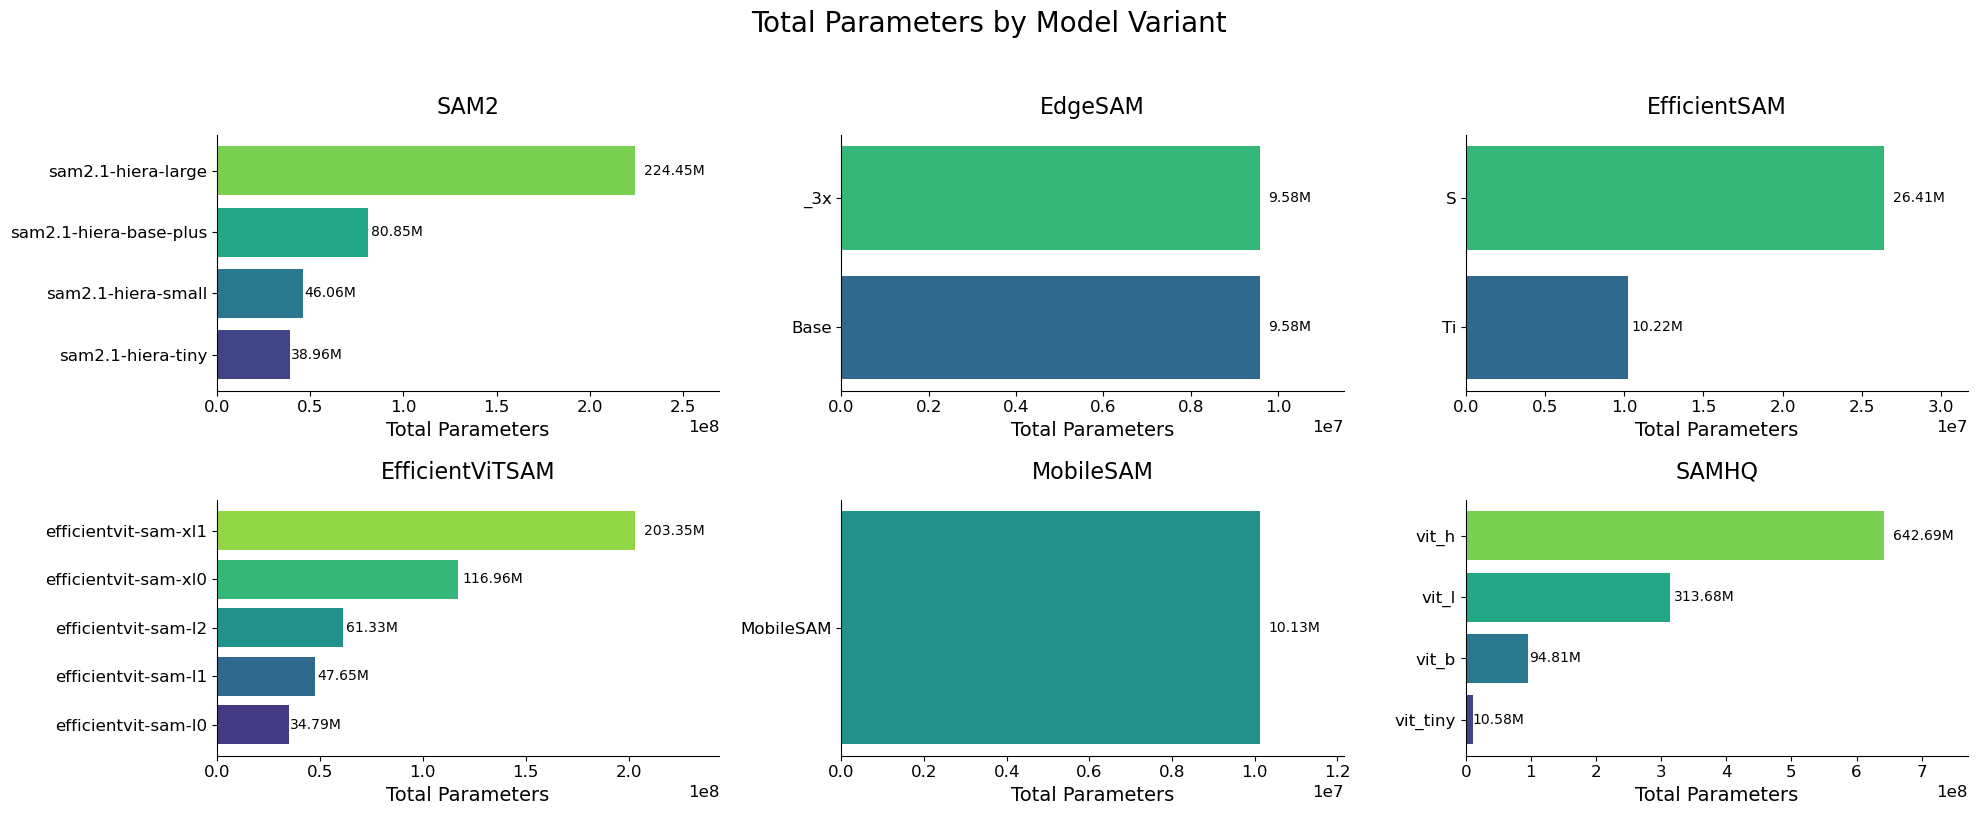

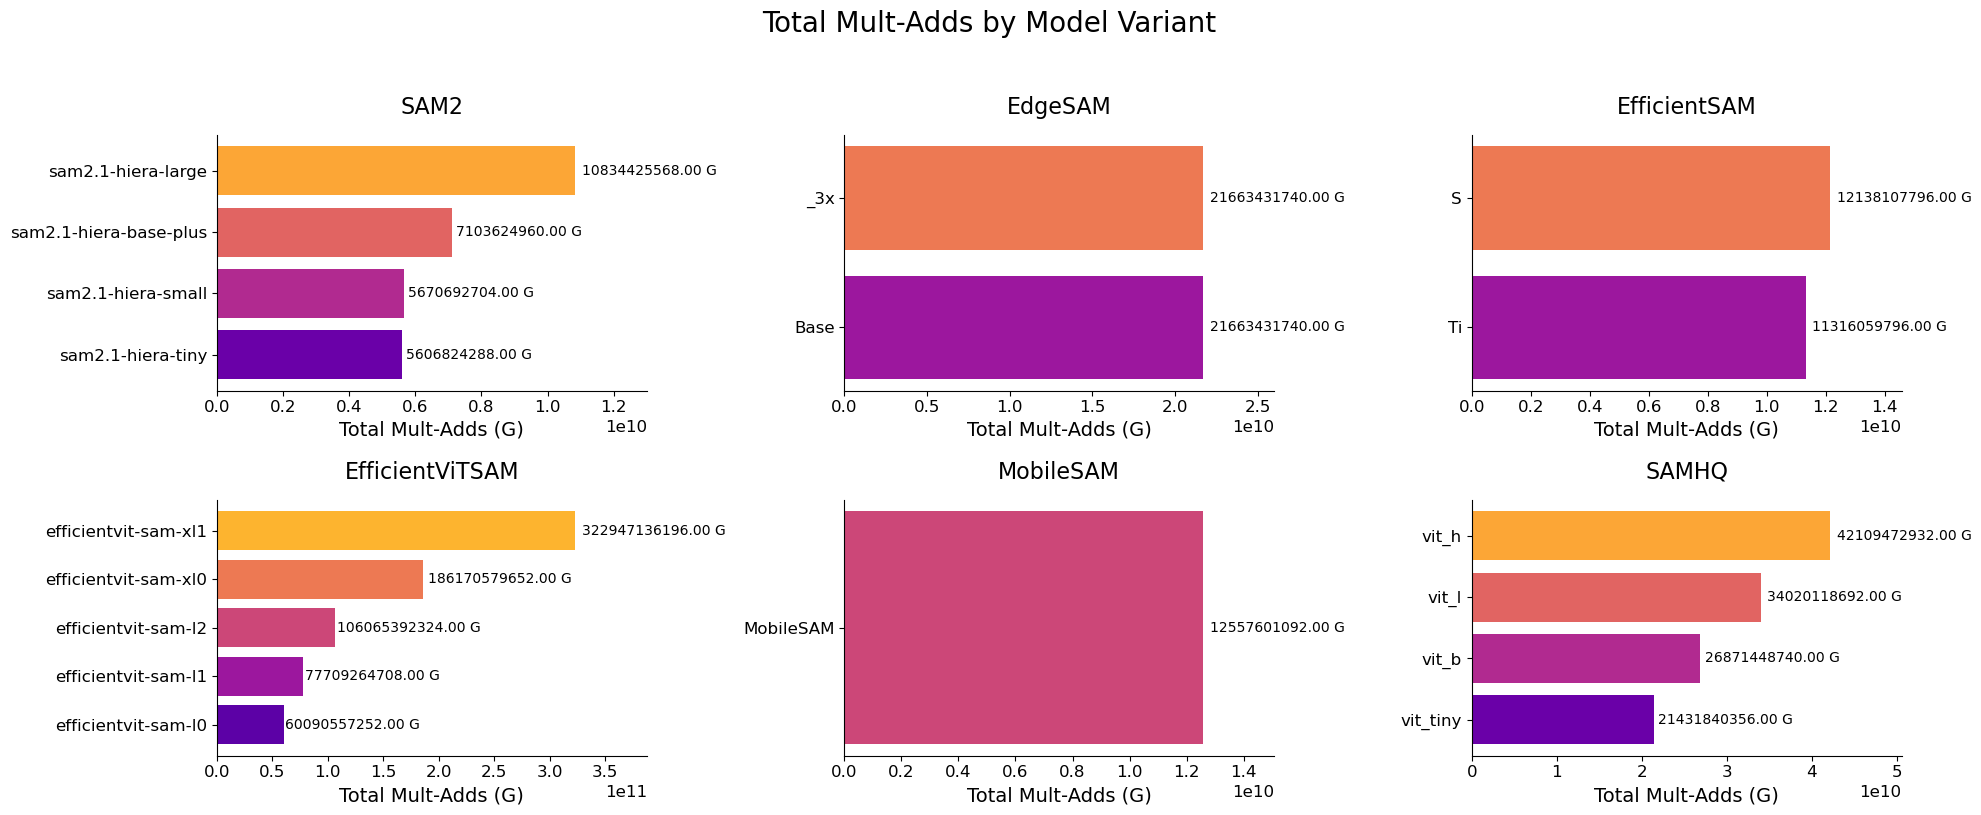

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import json
import os

models_and_variants = {
    "SAM2": ["facebook/sam2.1-hiera-tiny", "facebook/sam2.1-hiera-small", "facebook/sam2.1-hiera-large", "facebook/sam2.1-hiera-base-plus"],
    "EdgeSAM": ["Base", "_3x"],
    "EfficientSAM": ["S", "Ti"],
    "EfficientViTSAM": ["efficientvit-sam-xl1", "efficientvit-sam-l0", "efficientvit-sam-l1", "efficientvit-sam-l2", "efficientvit-sam-xl0"],
    "MobileSAM": ["MobileSAM"],
    "SAMHQ": ["vit_h", "vit_l", "vit_b", "vit_tiny"]
}

# Set global font sizes
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
})

# Load the data
json_filename = 'results/model_stats.json'
with open(json_filename, 'r') as f:
    model_stats = json.load(f)

# Convert to a DataFrame
records = []
for model, variants_data in model_stats.items():
    for variant, stats in variants_data.items():
        # stats should have "TotalParams" and "TotalMultAdds"
        records.append({
            'model': model,
            'variant': variant,
            'TotalParams': stats['TotalParams'],
            'TotalMultAdds': stats['TotalMultAdds']
        })

df = pd.DataFrame(records)

# Remove any "facebook/" prefix if present (similar to previous code)
df['variant'] = df['variant'].str.replace("facebook/", "")

# Create subplots for TotalParams and TotalMultAdds separately
# We will reuse a similar logic as the throughput code.

# 1) Visualization for TotalParams
fig_params, axes_params = plt.subplots(2, 3, figsize=(20, 8))
fig_params.suptitle('Total Parameters by Model Variant', fontsize=20, y=1.02)
axes_params_flat = axes_params.flatten()

unique_models = df['model'].unique()
for idx, model_name in enumerate(unique_models):
    ax = axes_params_flat[idx]
    subset = df[df['model'] == model_name].copy()
    # Sort by TotalParams ascending
    subset = subset.sort_values('TotalParams')
    
    # Create horizontal bar plot
    bars = ax.barh(subset['variant'], subset['TotalParams'],
                   color=sns.color_palette('viridis', n_colors=len(subset)))
    
    # Add value labels
    for bar in bars:
        width = bar.get_width()
        ax.text(width * 1.02,
                bar.get_y() + bar.get_height()/2,
                f'{width/1e6:.2f}M',  # display in millions, for example
                ha='left', va='center', fontsize=10)
    
    ax.set_title(f'{model_name}', fontsize=16, pad=15)
    ax.set_xlabel('Total Parameters', fontsize=14)
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(x=0.2)

# Remove extra subplots if any
for i in range(len(unique_models), len(axes_params_flat)):
    fig_params.delaxes(axes_params_flat[i])

plt.tight_layout()
os.makedirs('results', exist_ok=True)
plt.savefig('results/total_params_by_variant.svg', format='svg', bbox_inches='tight', dpi=300)
plt.show()

# 2) Visualization for TotalMultAdds
fig_multadds, axes_multadds = plt.subplots(2, 3, figsize=(20, 8))
fig_multadds.suptitle('Total Mult-Adds by Model Variant', fontsize=20, y=1.02)
axes_multadds_flat = axes_multadds.flatten()

for idx, model_name in enumerate(unique_models):
    ax = axes_multadds_flat[idx]
    subset = df[df['model'] == model_name].copy()
    # Sort by TotalMultAdds ascending
    subset = subset.sort_values('TotalMultAdds')
    
    # Create horizontal bar plot
    bars = ax.barh(subset['variant'], subset['TotalMultAdds'],
                   color=sns.color_palette('plasma', n_colors=len(subset)))
    
    # Add value labels
    for bar in bars:
        width = bar.get_width()
        ax.text(width * 1.02,
                bar.get_y() + bar.get_height()/2,
                f'{width:.2f} G',  # G for giga operations
                ha='left', va='center', fontsize=10)
    
    ax.set_title(f'{model_name}', fontsize=16, pad=15)
    ax.set_xlabel('Total Mult-Adds (G)', fontsize=14)
    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.margins(x=0.2)

# Remove extra subplots if any
for i in range(len(unique_models), len(axes_multadds_flat)):
    fig_multadds.delaxes(axes_multadds_flat[i])

plt.tight_layout()
plt.savefig('results/total_mult_adds_by_variant.svg', format='svg', bbox_inches='tight', dpi=300)
plt.show()
